# Computing thermal conductivity of a rotor chain via NEMD

 **Authors: Alessandra Iacobucci, Elisa Marini, Raphael Gastaldello** 


Objective: simulate a one-dimensional chain of classical rotors , with interaction potential
$$V(r) = 1 - \cos(r)$$
Coupled to boundary heat baths and subject to thermal forcing to estimate its thermal conductivity using the NEMD (Nonequilibrium Molecular Dynamics) approach. Rotor chains have finite thermal conductivity (see Giardinà _et al_ (2000), Gendelman and Savin (2000,2005), Yang and Hu (2005), Das and Dhar (2014).} $\kappa_N$ dramatically decreasing for $\bar{T} > 0.5$ (Giardin\'a {\it et al.} (2000))

## Parameters:

- chain length $10 \le n \le 100$
- no pinning ($U=0$)
- boundary temperatures: $T_L = T_{\mathrm{eq}} - \Delta T / 2$, $T_R = T_{\mathrm{eq}} + \Delta T / 2$ with $T_{\mathrm{eq}} < 0.5$
- boundary conditions: fixed on the left and free on the right
- friction parameters: $\xi_L=1$, $\xi_R=1$
- thermalization time steps `Nt_thrm`
- simulation time steps `Nt_sim`
- time step `dt` $\in[0.001,0.5]$ (depending on the chosen integration scheme)

## Dynamics:
Recall the equations: for all $i \in [[1,n]]$
$$
dq_i = p_i \, dt
$$
$$
dp_i = - \Big( V'(q_i-q_{i-1}) - V'(q_{i+1}-q_i)\Big) dt
+ \delta_{i,1} \Big( -\xi p_1 \, dt + \sqrt{2\xi T_L} \, dW_{1,t}\Big)
+ \delta_{i,n} \Big( -\xi p_n \, dt + \sqrt{2\xi T_R} \, dW_{n,t}\Big)
$$
Integration schemes: BABO, OBABO, ...

## Steps

- Initialize the system: Ensure the initial positions and momenta are appropriately set. This includes thermalizing with the correct initial conditions.

- Run the dynamics: Integrate the equations of motion using the numerical scheme provided.

- Make sure the system reaches a stationary state: check for local equilibrium by plotting the histogram of the marginals in $q$ and $p$ 

- Compute the energy current, using $j_{i,i+1} =-\dfrac 1 2 (p_i + p_{i+1}) V'(q_{i+1}-q_i)$

- Compute $$ \widehat\kappa_n^{N_\text{Niter}} = \frac 1{\Delta T} \frac 1{N_\text{Niter}}
		\sum_{m=1}^{N_\text{Niter}} J_n(q^m, p^m)$$

Optional

- Plot the temperature profile in the chain $T_i = \mathbb{E}_{\mu_{\Delta T, \Delta t}}[p_i^2]$, $i \in [[1,n]]$.
- Plot the instantaneous total current

In [1]:
# using Pkg; 
# Pkg.add("Random")
using Random
using Statistics
using Distributions
using Plots
import Pkg; Pkg.add("NumericalIntegration")
using SpecialFunctions, NumericalIntegration # or QuadGK

In [2]:
# setting global scope parameter values
const n = 10     # number of atoms
const BCl = "fixed"
const BCr = "free"
const Nt_thrm = 500000  # number of thermalization time steps
const Nt_sim =  100000000   # number of simulation time steps
const dt = 0.01 # time step
const T_eq = 0.3   # reference equilibrium temperature
const ΔT = 0.096  # temperature difference at the boundaries
const ξ_L = 1.0
const ξ_R = 1.0
const potential = "rotor" # alternatives: harmonic, FPUT, Toda
const ω0 = 0     # pinning potential
const ω = 1  # for harmonic and harmonic part in FPUT
const α = 1  # for FPUT
const β = 1  # idem
const a = 1  # for Toda
const b = 1  # idem
const storage_interval = 10 # save q's and p's for histograms every storage_interval iterations
const seed = 1234    # fix a random seed to ensure reproducibility 

1234

In [3]:
function initialize_T_profile() # uses global (T_eq, ΔT, n)
    Tleft = T_eq - ΔT/2; Tright = T_eq + ΔT/2; 
    if (Tleft < 0) || (Tright < 0) 
        error("negative temperature, be sure that ΔT < T_eq, ")
    end
    return Tleft .+ ΔT/(n-1) .* (0:(n-1)) # linear imposed_T_profile
end

initialize_T_profile (generic function with 1 method)

In [4]:
function initialize_chain(T_profile) # uses global n
    q = (potential == "rotor") ? (2π * rand(n) .- π) : zeros(n) 
    p = sqrt.(T_profile) .* randn(n)  
    return q, p
end

initialize_chain (generic function with 1 method)

In [5]:
# Interaction potentials and forces (choices); 
function interaction_potential(r) # uses global (ω, α, β, a, b, potential) # α and β for FPUT; a and b for Toda; return int_pot
    if potential == "rotor"
        return 1 .- cos.(r)
    elseif potential == "harmonic"
        return 0.25 * ω^2 .* r.^2  
    elseif potential == "FPUT"
        return 0.5 * ω^2 .* r.^2 .+ α / 3 .* r.^3 .+ β * 0.25 .* r.^4 
    elseif potential == "Toda"
        return a/b .* exp.(r) .+ a .* r .- a/b  
    else
        error("Unknown potential: $potential")
    end
end
 
function interaction_force(r) # uses global (ω, α, β, a, b, potential)     # return int_f
    if potential == "rotor"
        return - sin.(r)
    elseif potential == "harmonic"
        return - ω^2 .* r
    elseif potential == "FPUT"
        return - ω^2 .* r .- α .* r.^2 .- β .* r.^3
    elseif potential == "Toda"
        return a .* (1 .- exp.(-b .* r))
    else
        error("Unknown potential: $potential")
    end
end

interaction_force (generic function with 1 method)

In [6]:
# Pinning potential and force
function pinning_potential(q) # uses global ω0  # return pin_pot
    return ω0^2/2 .* q.^2 
end

function pinning_force(q) # uses global ω0  # return pin_f
    return - ω0^2 .* q # pin_f
end

pinning_force (generic function with 1 method)

In [7]:
function compute_dist_wt_BC(q) # uses global (n, BCl="free", BCr ="free")
    dist_vec_wt_BC = zeros(n+1)
    dist_vec_wt_BC[2:(end-1)] = q[2:end] - q[1:(end-1)]
    
    if BCl == "fixed"
        dist_vec_wt_BC[1] = q[1] # q_1-q_0 with q_0=0
    elseif BCl == "periodic"
        dist_vec_wt_BC[1] = q[1] - q[n] # q_1-q_0 with q_0=q_n
    end
    
    if BCr == "fixed"
        dist_vec_wt_BC[n] = -q[n] # q_(n+1)-q_n with q_(n+1) =0
    elseif BCr == "periodic"
        dist_vec_wt_BC[n] =  q[1] - q[n] # q_(n+1)-q_n with q_(n+1) = q_1
    end

    if potential == "rotor"
        dist_vec_wt_BC .= mod.(dist_vec_wt_BC .+ π, 2π) .- π
    end

    return dist_vec_wt_BC   # dim n+1
end

compute_dist_wt_BC (generic function with 1 method)

In [8]:
function ham_force_field_per_site(q) # uses global (n, ω0, ω, α, β, a, b, potential, BCl, BCr)
    r = compute_dist_wt_BC(q) #, n, BCl, BCr)
    int_f = interaction_force(r)
    pin_f = pinning_force(q)
    return int_f[1:(end-1)] - int_f[2:end] + pin_f
end

ham_force_field_per_site (generic function with 1 method)

In [9]:
function OU_step!(p, thrm_atoms::Vector{Int}, T_vec::Vector{Float64}, ξ_vec::Vector{Float64}, a) 
# uses global dt  
    mydt = a*dt
    if length(T_vec) != length(thrm_atoms) || length(ξ_vec) != length(thrm_atoms)
        error("OU_step!(): length(T_vec) and/or length(ξ) differ from length(thrm_atoms), stopping...")
    end
    α = exp.(-ξ_vec .* mydt)
    σ = sqrt.((1 .- α .^ 2) .* T_vec)
    # p[thrm_atoms] is a sub‐vector, like doing p[[1,n]] or p[1:n]
    p[thrm_atoms] .= α .* p[thrm_atoms] .+ σ .* randn(length(thrm_atoms))
end

OU_step! (generic function with 1 method)

In [10]:
function step_verlet!(q, p, thrm_atoms::Vector{Int}, T_vec::Vector{Float64}, ξ_vec::Vector{Float64}, f)  #BABO
# uses global (n, dt, ω0, ω, α, β, a, b, potential, BCl, BCr)
    
    p .+= 0.5dt .* f
    q .+= dt .* p
    if potential == "rotor"
        q .= mod.(q .+ π, 2π) .- π
    end
    
    f .= ham_force_field_per_site(q)
    p .+= 0.5dt .* f

    OU_step!(p, thrm_atoms, T_vec, ξ_vec, 1)
end

step_verlet! (generic function with 1 method)

In [11]:
function step_baoab!(q, p, thrm_atoms::Vector{Int}, T_vec::Vector{Float64}, ξ_vec::Vector{Float64}, f)
# uses global (n, dt, ω0, ω, α, β, a, b, potential, BCl, BCr)
    
    # B (first half)
    p .+= 0.5dt .* f

    # A (first half)
    q .+= 0.5dt .* p
    if potential == "rotor"
        q .= mod.(q .+ π, 2π) .- π
    end

    # O (OU on thermostatted atoms)
    OU_step!(p, thrm_atoms, T_vec, ξ_vec, 0.5)
    
    # A (second half)
    q .+= 0.5dt .* p
    if potential == "rotor"
        q .= mod.(q .+ π, 2π) .- π
    end

    # B (second half)
    f .= ham_force_field_per_site(q)
    p .+= 0.5dt .* f
end

step_baoab! (generic function with 1 method)

In [12]:
function simulate(scheme) # uses global (n, dt, Nt_sim, T_eq, ΔT, potential="rotor")

    Random.seed!(seed)  # to be able to reproduce the results
    
    imposed_T_profile = initialize_T_profile()# (T_eq, ΔT, n)
    q, p = initialize_chain(imposed_T_profile)

    computed_T_profile = zeros(n)
    Jntot = zeros(Nt_sim)
    r_hist = [] 
    p_hist = []

    f = ham_force_field_per_site(q)

    if scheme == "verlet"

        thrm_atoms = collect(1:n)    # thermalization phase
        ξ_vec = ones(length(thrm_atoms))
        for step in 1:Nt_thrm  
            step_verlet!(q, p, thrm_atoms, imposed_T_profile[thrm_atoms], ξ_vec, f)
        end
        
        thrm_atoms = [1,n]  # simulation phase
        ξ_vec = [ξ_L, ξ_R]
        for step in 1:Nt_sim
            step_verlet!(q, p, thrm_atoms, imposed_T_profile[thrm_atoms], ξ_vec, f)
            computed_T_profile .+= p .^ 2
            Jntot[step] = sum(0.5 .* (p[1:end-1] +p[2:end]) .* f[2:end])
            #if step % storage_interval == 0
            #    r = compute_dist_wt_BC(q)[1:n]
            #    push!(r_hist, copy( [r[floor(Int,n/4)], r[floor(Int,n/2)], r[floor(Int,3*n/4)]] ))
            #    push!(p_hist, copy( [p[floor(Int,n/4)], p[floor(Int,n/2)], p[floor(Int,3*n/4)]] ))
            #end
        end
        
    elseif scheme == "baoab"
        
        thrm_atoms = collect(1:n)    # thermalization phase
        ξ_vec = ones(length(thrm_atoms))
        for step in 1:Nt_thrm  
            step_baoab!(q, p, thrm_atoms, imposed_T_profile[thrm_atoms], ξ_vec, f)
        end
        
        thrm_atoms = [1,n]  # simulation phase
        ξ_vec = [ξ_L, ξ_R]
        for step in 1:Nt_sim
            step_baoab!(q, p, thrm_atoms, imposed_T_profile[thrm_atoms], ξ_vec, f)
            computed_T_profile .+= p .^ 2
            Jntot[step] = sum(0.5 .* (p[1:end-1] +p[2:end]) .* f[2:end])
            #if step % storage_interval == 0
            #    r = compute_dist_wt_BC(q)[1:n]
            #    push!(r_hist, copy( [r[floor(Int,n/4)], r[floor(Int,n/2)], r[floor(Int,3*n/4)]] ))
            #    push!(p_hist, copy( [p[floor(Int,n/4)], p[floor(Int,n/2)], p[floor(Int,3*n/4)]] ))
            #end
        end
        
    else
        error("Unknown integration scheme: $scheme")
    end

    # compute temperature profile
    computed_T_profile ./= Nt_sim

    return r_hist, p_hist, computed_T_profile, Jntot
end

simulate (generic function with 1 method)

In [13]:
function NEMD_estimate_of_conductivity(Jntot) # (Jntot, ΔT)
    return - mean(Jntot) / ΔT # κ, minus sign for Fourier's law convention
end

NEMD_estimate_of_conductivity (generic function with 1 method)

In [14]:
# Nt_thrm = 100000  # number of thermalization time steps
# Nt_sim =  10000000   # number of simulation time steps
# dt = 0.001 # time step
println("Running Verlet scheme...")
r_hist, p_hist, computed_T_profile, Jntot = simulate("verlet")
if ΔT != 0.0
    κ_v = NEMD_estimate_of_conductivity(Jntot)
end
println("Average total current (Verlet): ", mean(Jntot))
println("Estimated conductivity (Verlet): ", κ_v)

Running Verlet scheme...
Average total current (Verlet): -0.09934638712248511
Estimated conductivity (Verlet): 1.0348581991925532


In [15]:
function plot_histograms(r_hist, p_hist, Ts)
    for idx in 1:length(r_hist[1]) # = length(phist(1))

        β = 1/Ts[idx]

        # POSITIONS
        rs = [r[idx] for r in r_hist]  # this takes the idx component of all the entries, so the result is the time evolution of the position of the idx-th particle
        histogram(rs, bins=50, normalize=true, title="Position at site $(floor(idx*n/4))", label="")

        # define support for theroetical density
        if potential == "rotor"
            xs = range(-π, π; length=400)
        else
            xmin, xmax = extrema(rs)
            pad   = 0.1*(xmax - xmin)
            xs    = range(xmin - pad, xmax + pad; length=400)
        end

        # un-normalised probability density function
        ψ = exp.(-β .* interaction_potential(xs))

        Z  = 2π * exp(-β) * besseli(0, β)      # exact normalising constant for rotors
        # numerical normalisation if no closed form
        # Z = quadgk(x -> exp(-β*interaction_potential(x)), first(xs), last(xs); rtol=1e-8)[1]
        # Z = trapz(xs, f)         # or quadgk, as before

        plot!(xs, ψ ./ Z; lw=2, label="C·exp(-β·V(r))")
        display(current())

        # MOMENTA
        ps = [p[idx] for p in p_hist]
        histogram(ps, bins=50, normalize=true, title="Velocity at site $(floor(idx*n/4))", label="")
        # theoretical density
        ys = range(minimum(ps), maximum(ps); length=400)
        plot!(ys, pdf.(Normal(0, β^(-1/2)), ys); lw=2, label="N(0, T)")

        display(current())
    end
end

plot_histograms (generic function with 1 method)

In [16]:
# plot_histograms(r_hist, p_hist, computed_T_profile[[n ÷ 4, n ÷ 2, 3n ÷ 4]])

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [1]

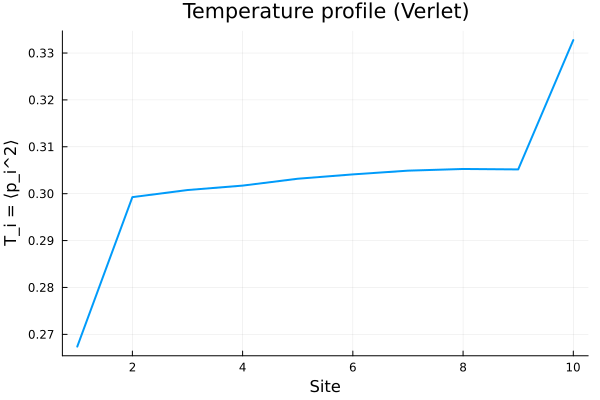

In [17]:
plot(1:n, computed_T_profile, xlabel="Site", ylabel="T_i = ⟨p_i^2⟩", title="Temperature profile (Verlet)", lw=2, legend=false)

In [ ]:
plot(1:Nt_sim, Jntot, xlabel="time step", ylabel="J_n", title="Total instantaneous current (Verlet)", lw=2, legend=false)
plot!(1:Nt_sim, cumsum(Jntot)./(1:Nt_sim))

In [ ]:
# Nt_thrm = 100000  # number of thermalization time steps
# Nt_sim =  10000000   # number of simulation time steps
# dt = 0.001 # time step
println("Running BAOAB scheme...")
r_hist, p_hist, computed_T_profile, Jntot = simulate("baoab")
if ΔT != 0.0
    κ_b = NEMD_estimate_of_conductivity(Jntot)
end
println("Average total current (BAOAB): ", mean(Jntot))
println("Estimated conductivity (BAOAB): ", κ_b)

In [ ]:
# plot_histograms(r_hist, p_hist, computed_T_profile) #, [n ÷ 4, n ÷ 2, 3n ÷ 4]

In [ ]:
plot(1:n, computed_T_profile, xlabel="Site", ylabel="T_i = ⟨p_i²⟩", title="Temperature profile (BAOAB)", lw=2, legend=false)

In [ ]:
# plot(1:Nt_sim, Jntot, xlabel="time step", ylabel="J_n", title="Total instantaneous current (BAOAB)", lw=2, legend=false)
# plot!(1:Nt_sim, cumsum(Jntot)./(1:Nt_sim))

# Synthetic forcing

In [ ]:
# changing global scope parameter values as needed

ΔT = 0. # temperature difference at the boundaries

# Nt_thrm = 5000000 # number of thermalization time steps
# Nt_sim =  100000000 # number of simulation time steps

const η = 0.25 # total perturbation magnitude, it will be divided by n-1

println("\n η = ", η)

In [ ]:
# modifying function computing the hamiltonian vector field
# r = dist_vec_wt_BC, dim n+1
function ham_force_field_per_site_nonphys(q) # uses global (η, n)
    
    r = compute_dist_wt_BC(q) # differences of angles + modulus
    int_f = interaction_force(r) # - sin(r) = [-sin(r_1), ..., -sin(r_{n+1})] = - V'(r)
    
    ν = η/(n-1)
    
    ham_force_field_Lsite = int_f[1] .- (1-ν) .* int_f[2]  # only - v'(r_1) + (1 - ν) * v'(r_2) in dp_1
    ham_force_field_bulk_sites = (1 .+ ν) .* int_f[2:(n-1)] .- (1 .- ν) .* int_f[3:n]
    ham_force_field_Rsite = (1 .+ ν) .* int_f[n] .- int_f[n+1] # for dp_N

   return [ham_force_field_Lsite; ham_force_field_bulk_sites; ham_force_field_Rsite] # concatenate in unique vector field n components

end

In [ ]:
# f = ham_force_field_per_site(q)
function step_verlet_nonphys!(q, p, thrm_atoms::Vector{Int}, T_vec::Vector{Float64}, ξ_vec::Vector{Float64}, f)  #BAO
# uses global (n, dt, ω0, ω, α, β, a, b, potential, BCl, BCr)
    
    p .+= 0.5dt .* f
    q .+= dt .* p
    if potential == "rotor"
        q .= mod.(q .+ π, 2π) .- π
    end
    
    f .= ham_force_field_per_site_nonphys(q)
    p .+= 0.5dt .* f

    OU_step!(p, thrm_atoms, T_vec, ξ_vec, 1) 
end

In [ ]:
# interaction_force = - V'
function compute_Jntot(q,p) # observable does not change: use interaction_force with no perturbation

    en_flux = 0.
    r = compute_dist_wt_BC(q) 

    en_flux = sum(0.5 .* (p[1:n-1] .+ p[2:n]) .* interaction_force(r[2:n])) # no ν here, observable does not change

    return en_flux
end

In [ ]:
# rescaled estimated coefficient
function NEMD_estimate_of_conductivity_and_error_synth(Jntot)

    c = 1. / (T_eq)
    κ = ( abs(mean(Jntot)) / η ) * c 

    return κ 
end

In [ ]:
function simulate_synth(scheme) # uses global (n, dt, Nt_sim, T_eq=1.0, ΔT=0.5, potential="rotor")
    
    imposed_T_profile = initialize_T_profile() 
    q, p = initialize_chain(imposed_T_profile)

    computed_T_profile = zeros(n)
    Jntot = zeros(Nt_sim)
    q_hist = [] 
    p_hist = []

    f = ham_force_field_per_site(q) # do not add perturbation for the moment

    if scheme == "verlet"

        thrm_atoms = collect(1:n)    # thermalization phase
        ξ_vec = ones(length(thrm_atoms))
        for step in 1:Nt_thrm  
            step_verlet!(q, p, thrm_atoms, imposed_T_profile[thrm_atoms], ξ_vec, f) # do not add perturbation during thermalization
        end
        
        # we modify only the simulation phase adding a perturbation of the field
        thrm_atoms = [1,n]  
        ξ_vec = [ξ_L, ξ_R]
        for step in 1:Nt_sim # simulation phase: turn perturbation on
            
            step_verlet_nonphys!(q, p, thrm_atoms, imposed_T_profile[thrm_atoms], ξ_vec, f) # use perturbed field in the integration scheme
            
            computed_T_profile .+= p .^ 2

            Jntot[step] = compute_Jntot(q,p) # do not use pertrubed field for the observable
        end
        
    elseif scheme == "baoab"
        
        # same modifications
        
    else
        error("Unknown integration scheme: $scheme")
    end

    # compute temperature profile
    computed_T_profile ./= Nt_sim

    return q_hist, p_hist, computed_T_profile, Jntot
end

In [ ]:
println("Running Verlet scheme...")
_, _, _, Jntot = simulate_synth("verlet")

κ_synth_v = NEMD_estimate_of_conductivity_and_error_synth(Jntot)
println("Estimated conductivity (synth, Verlet): ", κ_synth_v)

#println("Running BAOAB scheme...")
#_, _, _, Jntot = simulate_synth("baoab")
#κ_synth_b = NEMD_estimate_of_conductivity_and_error_synth(Jntot)
#println("Estimated conductivity (synth, BAOAB): ", κ_synth_b)


println("Estimated conductivity (Verlet): ", κ_v)
println("Estimated conductivity (BAOAB): ", κ_b)

# Green--Kubo formula 

For two observables$~R,S \in L^2(\mu)$, we have
$$
\alpha = \int_0^{+\infty}\mathbb{E}\!\left[R(q_t,p_t)S(q_0,p_0) \right] \mathrm{d} t.
$$
First, we need to truncate the time integral
$$
\widehat{\alpha}_\tau = \int_0^{\tau}\mathbb{E}\!\left[R(q_t,p_t)S(q_0,p_0) \right] \mathrm{d} t.
$$
Then, the numerical estimator that we implement is given by a Monte-Carlo method and a time integration:
$$
\widehat{\alpha}_{\tau,K} = \frac{\Delta t}{K}\sum_{k = 1}^{K}\sum_{n = 0}^{N_{\text{iter}}} R(q^{n,(k)},p^{n,(k)})S(q^{0,(k)},p^{0,(k)}),
$$
where$~(q^{n,(k)},p^{n,(k)})_{1\leq K}$ are i.i.d realizations.


#### Since the Green--Kubo formula is an equilibrium technique, we can instead use a very long dynamics and cut it into differents pieces of the same size. It will be the way that we proceed.

### Two important properties

- Exponentional decay of the autocorrelation :
        $$
               \left| \mathbb{E}\!\left[R(q_t,p_t)S(q_0,p_0) \right] \right| \sim_{t \rightarrow +\infty} C \exp(-\lambda t).
        $$
- Linear growth, with respect to time, of the variance :
         $$
               Var(\widehat{\alpha}_{\tau,K}) \sim_{\tau \rightarrow +\infty} C_2 \tau
        $$
### Application to the thermal conductivity
The previous thermal conductivity coefficient, that you obtained before, can be computed by the Green--Kubo formula. Indeed, we have
$$
\kappa = \frac{\beta^2}{N-1}\int_0^{+\infty}\mathbb{E}\!\left[J(q_t,p_t)J(q_0,p_0) \right] \mathrm{d} t,
$$
with~$\beta = 1/T_{\text{ref}}$.

$\textit{Remark:}$ The Green--Kubo formula is an equilibrium formula, so the temperature at each end is the same.

## Hands on
First, we need to be at equilibrium, so we need to set $\Delta T = 0$. We also declare again the number of time integration since we will be playing on it. 
#### IF YOU ARE CHANGING THE CONST, REMEMBER TO RELOAD THE FUNCTIONS BELOW

In [ ]:
const ΔT = 0.0
const T_eq = 0.3
const Nt_sim =  100000000

Since we will be considering a long trajectory and the current $J$, we need to generate a long vector of $J$.

We rewrite the function "simulate" such that it only returns the current.

In [ ]:
function simulate(scheme) # uses global (n, dt, Nt_sim, T_eq=1.0, ΔT=0.5, potential="rotor")
    
    imposed_T_profile = initialize_T_profile()# (T_eq, ΔT, n)
    q, p = initialize_chain(imposed_T_profile)

    Jntot = zeros(Nt_sim)
    f = ham_force_field_per_site(q)

    if scheme == "verlet"


        thrm_atoms = collect(1:n)    # thermalization phase
        ξ_vec = ones(length(thrm_atoms))
        for step in 1:Nt_thrm
            step_verlet!(q, p, thrm_atoms, imposed_T_profile[thrm_atoms], ξ_vec, f)
        end
        
        thrm_atoms = [1,n]  # simulation phase
        ξ_vec = [ξ_L, ξ_R]
        for step in 1:Nt_sim
            step_verlet!(q, p, thrm_atoms, imposed_T_profile[thrm_atoms], ξ_vec, f)
            Jntot[step] = sum(0.5 .* (p[1:end-1] +p[2:end]) .* f[2:end])
        end
        
    elseif scheme == "baoab"
        
        thrm_atoms = collect(1:n)    # thermalization phase
        ξ_vec = ones(length(thrm_atoms))
        for step in 1:Nt_thrm  
            step_baoab!(q, p, thrm_atoms, imposed_T_profile[thrm_atoms], ξ_vec, f)
        end
        
        thrm_atoms = [1,n]  # simulation phase
        ξ_vec = [ξ_L, ξ_R]
        for step in 1:Nt_sim
            step_baoab!(q, p, thrm_atoms, imposed_T_profile[thrm_atoms], ξ_vec, f)
            Jntot[step] = sum(0.5 .* (p[1:end-1] +p[2:end]) .* f[2:end])
        end
        
    else
        error("Unknown integration scheme: $scheme")
    end
    return Jntot
end

We first generate a "long" vector of current

In [ ]:
@time Jntot = simulate("baoab")  # "verlet"

In [ ]:
Nsub = 5000 # Number of time iterations of the time segments
Nrep = ceil(Int, Nt_sim/Nsub)   # Number of i.i.d replicas for Monte Carlo

We create a function to compute the autocorrelation function.

In [ ]:
function Autocor(Jntot, Nsub, Nrep)

    Auto = zeros(Nsub)

    @views for i in 1:Nsub:Nsub*Nrep
        J = @views Jntot[i:i+Nsub-1]
        J0 = J[1]
        @simd for j in 1:Nsub
            Auto[j] += J[j] * J0
        end
    end

    return Auto ./ Nrep
end

In [ ]:
@time A = Autocor(Jntot, Nsub, Nrep)

In [ ]:
plot(A, label = "Autocorrelation")
xlabel!("Time step")

In [ ]:
GreenKubo = dt/(T_eq^2*(n-1))*cumsum(A)

In [ ]:
plot(GreenKubo, label = "Green Kubo formula")
xlabel!("Time step")

#### To do 
Play with Nsub (and Nrep) to see the impact on the Green--Kubo formula.